# Image processing 1: Edge detection using a partially approximated adders

Authors: Vladislav Válek

In [2]:
# Loading required packages packages
from skimage import io, img_as_float, img_as_ubyte
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

### Exact Adder Function
The ExactAdder function performs binary addition on three input bits (a, b, and c). It outputs the sum (s) and carry-out (c_out) based on the combination of input bits. The function encapsulates the logic of a full adder, handling all possible input cases through conditional statements. It is a fundamental component in digital circuit design.


In [3]:
def ExactAdder(a, b, c):
    if a==0 and b==0 and c==0:
        s=0
        c_out=0
        energy_consumption = 4971
    elif a==0 and b==0 and c==1:
        s=1
        c_out=0
        energy_consumption = 123 
    elif a==0 and b==1 and c==0:
        s=1
        c_out=0
        energy_consumption = 3021 
    elif a==0 and b==1 and c==1:
        s=0
        c_out=1
        energy_consumption = 8293 
    elif a==1 and b==0 and c==0:
        s=1
        c_out=0
        energy_consumption = 2175 
    elif a==1 and b==0 and c==1:
        s=0
        c_out=1
        energy_consumption = 2397 
    elif a==1 and b==1 and c==0:
        s=0
        c_out=1
        energy_consumption = 1092 
    elif a==1 and b==1 and c==1:
        s=1
        c_out=1
        energy_consumption = 13
    return s, c_out, energy_consumption

## Approximate Adder Function
The ApproxAdder function attempts binary addition but deviates from conventional logic in its handling of input combinations. In particular, it provides an inaccurate sum (s) for the cases (0, 0, 0) and (1, 1, 1).

Failure Cases:

Input (0, 0, 0):
Incorrect sum (s) = 1 Correct carry-out (c_out) = 0

Input (1, 1, 1):
Incorrect sum (s) = 0 Correct carry-out (c_out) = 1

Considerations:
The function's approach to binary addition may have specific intentions, but users should be cautious about its accuracy, especially in scenarios requiring precise binary addition.

Function Usage:
Call the function with three binary inputs (a, b, and c) to obtain the potentially inaccurate sum (s) and correct carry-out (c_out).

In [4]:
def ApproxAdder(a, b, c):
    if a==0 and b==0 and c==0:
        s=1
        c_out=0
        energy_consumption = 984
    elif a==0 and b==0 and c==1:
        s=1
        c_out=0
        energy_consumption = 1098
    elif a==0 and b==1 and c==0:
        s=1
        c_out=0
        energy_consumption = 831 
    elif a==0 and b==1 and c==1:
        s=0
        c_out=1
        energy_consumption = 239 
    elif a==1 and b==0 and c==0:
        s=1
        c_out=0
        energy_consumption = 492 
    elif a==1 and b==0 and c==1:
        s=0
        c_out=1
        energy_consumption = 319 
    elif a==1 and b==1 and c==0:
        s=0
        c_out=1
        energy_consumption = 598 
    elif a==1 and b==1 and c==1:
        s=0
        c_out=1
        energy_consumption = 658 
    return s, c_out, energy_consumption


## N-bit Adder Function
The MyNbitAdder function is designed to perform N-bit addition, where the lower 4 bits utilize an approximate adder (ApproxAdder), and the remaining bits employ an exact adder (ExactAdder).

### Function Overview

Input Conversion:
Convert input integers a and b to binary and remove the binary prefix.

Byte Reversal:
Reverse the order of bits in both binary representations.

Equalizing Byte Length:
Ensure both binary representations have equal length by padding with zeros.

Bitwise Addition:
Perform bitwise addition, using either the approximate adder or exact adder based on the specified threshold (approx_until).

Result Calculation:
Calculate the total sum by summing up the bitwise results and accounting for any carry-over.

This function allows users to perform N-bit addition with a customizable threshold (approx_until) to switch between the approximate and exact adders. Adjust the threshold as needed for specific requirements.

In [5]:
#In 12 bit adder, lower 4 bits are implemented with approximate adder and rest of the with with exact adder
def MyNbitAdder(a,b, n = 12, approx_until = 0):
    #convert to binary and cut off the first two indices (they dont belong to the number but indicate that it is binary)
    n = 12
    a = (a + 2**(n - 1)) % 2**n - 2**(n - 1)
    b = (b + 2**(n - 1)) % 2**n - 2**(n - 1)

    a_bin = bin(a & ((1 << n) - 1))[2:].zfill(n)
    b_bin = bin(b & ((1 << n) - 1))[2:].zfill(n)

    #reverse order of bytes for the adder
    rev_a , rev_b = list(a_bin[::-1]), list(b_bin[::-1])
    
    carry_over   = 0
    total_sum    = 0
    total_energy = 0
    
    #we want to do a bitwise addition
    for index, (bit1, bit2) in enumerate( zip(rev_a, rev_b) ):

        if index < approx_until:
            #use approx_adder
            sum_element, carry_over, energy = ApproxAdder(int(bit1), int(bit2), int(carry_over) ) 
        else:
            #use exact_adder
            sum_element, carry_over, energy = ExactAdder(int(bit1), int(bit2), int(carry_over) )
            
        total_sum += pow(2,index)*sum_element
        total_energy += energy

    if total_sum >= 2**(n-1):
        total_sum -= 2**n 

    return total_sum, total_energy

test_cases = [
    (0, 0),     # 0 + 0 = 0
    (0, -1),     # 0 + -1 = -1
    (-1, 0),     # -1 + 0 = 0
    (5, 7),     # 5 + 7 = 12
    (-1, -1),   # -1 + -1 = -2 (overflow)
    (8, -3),    # 8 + (-3) = 5
    (-8, 3),    # -8 + 3 = -5
    (-8, -3),   # -8 + (-3) = -11
    (15, 1),    # 15 + 1 = -16 (overflow)
]

for a, b in test_cases:
    result,_ = MyNbitAdder(a, b)
    print(f"MyNbitAdder({a}, {b}) = {result}, should be {a+b}")

#MyNbitAdder(4,2)
MyNbitAdder(-1,-1)


MyNbitAdder(0, 0) = 0, should be 0
MyNbitAdder(0, -1) = -1, should be -1
MyNbitAdder(-1, 0) = -1, should be -1
MyNbitAdder(5, 7) = 12, should be 12
MyNbitAdder(-1, -1) = -2, should be -2
MyNbitAdder(8, -3) = 5, should be 5
MyNbitAdder(-8, 3) = -5, should be -5
MyNbitAdder(-8, -3) = -11, should be -11
MyNbitAdder(15, 1) = 16, should be 16


(-2, 1235)

## Image Adder Function
The ImageAdder function is designed to add two images represented as arrays (f and g). It utilizes a custom N-bit adder (MyNbitAdder) for element-wise addition of corresponding pixel values.

In [6]:
# Function that adds two images
def ImageAdder(f,g, approx_until = 0):
    
    # convert pixel values of both images to integers
    f=np.array(f).astype(int)
    g=np.array(g).astype(int)
    
    res = np.zeros(f.shape)
    total_energy = 0
    
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            
            #we will use a custom adding function
            res[i, j], energy = MyNbitAdder(f[i,j],g[i,j], approx_until = approx_until)
            total_energy += energy
    
    return res, total_energy

f = np.eye(3)
g = np.eye(3)
ImageAdder(f,g)

(array([[2., 0., 0.],
        [0., 2., 0.],
        [0., 0., 2.]]),
 510687)

## Filter Definition
The kernel or filter for convolution is defined as follows: This 3x3 filter is often used in image processing, particularly in Gaussian blur operations. Each element in the filter contributes to the weighted sum of pixel values during convolution, emphasizing the central pixel. Adjustments to the filter values can impact the characteristics of the convolution operation, such as blurring or edge detection.

In addition to the Gaussian filter mentioned above, we provide two types of filters classified as follows:

1) Low Pass Filter

f1: Low pass average filter

These filters are designed for tasks such as removing noise from images or smoothing/blurring images. The key characteristic is that the sum of all the kernel elements should be one.

2) High Pass Filter

f6: Sobel horizontal edge filter

High pass filters are utilized for edge detection or sharpening of images, and they have the property that the sum of all the kernel elements should be zero.

In [7]:
f1 = [
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
]
f1 = 1/9 *np.array(f1)

f6 = [
    [1,   2,   1],
    [0,   0,   0],
    [-1, -2,  -1]
]
f6 = np.array(f6)

# Homework Objective:
The objective of this homework is to explore the approximation of the "adding process" within the convolution operation. This involves defining functions for multi-adding (MultiAdder) and approximating convolution (MyConvAdder). The degree of approximation can be controlled by the variable approx_until. Additionally, we will compare the results of approximate convolution with an exact convolution using Python's own convolution function.


## Subtasks:
### 1.1 Define the "MultiAdder" Function (5 points):
Create a function called MultiAdder that takes a list/matrix of numbers and uses the MyAdder function to add them approximately.
The function should return the result of the multi-adding process.

In [8]:
def SumReduction(n, approx_until = 0):

    shap = n.shape
    n = np.array(n).astype(int)
    total_energy = 0

    if (len(shap) == 1):
        res = n[0]

        for i in range(1,shap[0]):
            res,energy = MyNbitAdder(res,n[i], approx_until = approx_until)
            total_energy += energy

    elif (len(shap) == 2):
        res = n[0,0]

        for i in range(shap[0]):
            for j in range(shap[1]):

                # There is no reason to calculating this because we are reducing a matrix so 
                # first element is only saved and the algorithm goes on.
                if (i == 0 and j == 0): continue

                res,energy = MyNbitAdder(res,n[i,j], approx_until = approx_until)
                total_energy += energy
    
    return res, total_energy

SumReduction(f6)

(0, 534108)

### 1.2 Import sample image

(277, 270, 3)
(277, 270)
[[254. 249. 255. ... 253. 241. 253.]
 [247. 255. 255. ... 255. 255. 254.]
 [250. 255. 231. ... 243. 255. 255.]
 ...
 [251. 255. 201. ... 253. 255. 255.]
 [245. 255. 247. ... 255. 255. 252.]
 [255. 253. 255. ... 254. 242. 255.]]


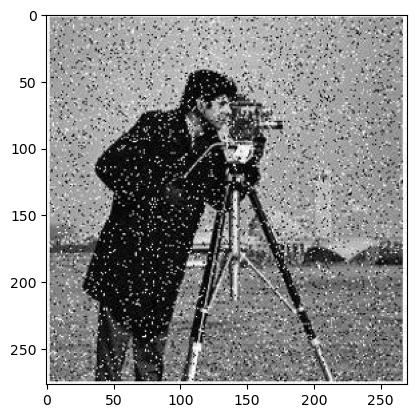

In [9]:
# Your code here
sample_image = io.imread("man.jpeg")
filter_kernel = f1
print(sample_image.shape)

R_1 = sample_image[:, :, 0] 
G_1 = sample_image[:, :, 1]
B_1 = sample_image[:, :, 2]

#formula for converting colour(RGB) to Gray Image scale Image
Y_sample = (0.299 * np.array(R_1)) + (0.587 * np.array(G_1)) + (0.114 * np.array(B_1)) 

plt.imshow(Y_sample , cmap = "gray")
print(Y_sample.shape)
print(Y_sample)

### 1.2 Define the "LaConvolution" Function (5 points):
Create a function called MyConvAdder that simulates the convolution operation using the MultiAdder function for the adding process.
The function should take an image and a 3x3 filter/kernel and return the convolved image.

In [24]:
def LaConvolution(image, kernel, approx_until = 0):
    x,y = image.shape
    k,l = kernel.shape
    # print(x,y)

    pad_image = np.pad(image, ((k // 2, k // 2),(l // 2, l // 2)), mode = "constant")
    xp, yp = pad_image.shape
    # print(pad_image.shape)
    # print(pad_image)

    flipped_kernel = np.flipud(np.fliplr(kernel))

    result = np.zeros_like(image)
    total_energy = 0

    for i in range(x):
        for j in range(y):
            # print(i,",", j)
            region = pad_image[i:i + k, j:j + l]
            result[i, j], energy = SumReduction(region * flipped_kernel, approx_until)

            total_energy += energy

    return result, energy

kern2 = [
    [0,1],
    [1,1]
]

kern3 = [
    [-1,2,1],
    [0,1,0],
    [1,2,-1]
]

kern4 = [
    [-1, 0, 1, 2],
    [ 0, 1, 2, 3],
    [ 1, 2, 3, 2],
    [ 2, 3, 2,-1]
]

random_matrix = [
    [12, 79, 27,  2, 45,  4, 41, 62],
    [ 0, 93,  4, 39, 24, 13, 76, 73],
    [35, 50, 36, 81,  3, 15, 50, 95],
    [80, 78, 61, 95,  5, 79, 12, 56],
    [95, 74, 65, 16, 89, 73, 13, 10],
    [51, 35, 34,  6, 25, 40,  3, 90],
    [84, 92, 32, 48, 17, 93,  5, 14],
    [52, 54, 32, 68, 79, 91, 68, 71]
]

# Tests:
exact_convol = signal.convolve2d(random_matrix, kern2, mode = "same")
appr_convol,_ = LaConvolution(np.array(random_matrix),np.array(kern2)) 

if (not np.array_equal(exact_convol, appr_convol)):
    print("Convolution with kern2 unsuccesful!")
    print("Exact convolution:")
    print(exact_convol.shape)
    print(exact_convol)
    print("My convolution:")
    print(appr_convol.shape)
    print(appr_convol)
else:
    print("SUCCESS: Convolution with kern2!")

exact_convol = signal.convolve2d(random_matrix, kern3, mode = "same")
appr_convol,_ = LaConvolution(np.array(random_matrix),np.array(kern3)) 

if (not np.array_equal(exact_convol, appr_convol)):
    print("Convolution with kern3 unsuccesful!")
    print("Exact convolution:")
    print(exact_convol.shape)
    print(exact_convol)
    print("My convolution:")
    print(appr_convol.shape)
    print(appr_convol)
else:
    print("SUCCESS: Convolution with kern3!")

exact_convol = signal.convolve2d(random_matrix, kern4, mode = "same")
appr_convol,_ = LaConvolution(np.array(random_matrix),np.array(kern4)) 

if (not np.array_equal(exact_convol, appr_convol)):
    print("Convolution with kern4 unsuccesful!")
    print("Exact convolution:")
    print(exact_convol.shape)
    print(exact_convol)
    print("My convolution:")
    print(appr_convol.shape)
    print(appr_convol)
else:
    print("SUCCESS: Convolution with kern4!")

SUCCESS: Convolution with kern2!
SUCCESS: Convolution with kern3!
SUCCESS: Convolution with kern4!


### 1.3 Using filters

In [11]:
f1_img, enrg = LaConvolution(Y_sample,f1)
print(f1_img.shape)
print(enrg)
print(f1_img)
plt.imshow(f1_img, cmap = "gray")

(277, 270)
(3, 3)


KeyboardInterrupt: 

(277, 270)
275744


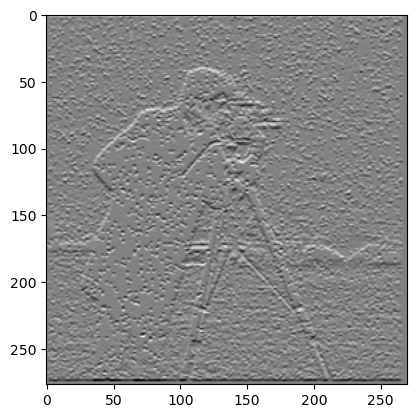

In [88]:
filt6_img, enrg = LaConvolution(Y_sample,f6)
print(filt6_img.shape)
print(enrg)
plt.imshow(filt6_img, cmap = "gray")

### 1.4 Perform Approximate and Exact Convolution (5 points):
Use the MyConvAdder function to perform approximate convolution.
Use Python's own convolution function (e.g., from scipy.signal) to perform exact convolution.
Compare the results and calculate the error and similarity between the two convolution outputs.

In [91]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

exact_convolution_result = signal.convolve2d(Y_sample, f6, mode = "valid")

# Your code here
for i in range(7):
    print("Number of approximated bits on addition: ", i)
    approx_convolution_result,_ = LaConvolution(Y_sample, f6 , i)
   

    exact_convolution_result = np.resize(exact_convolution_result, np.shape(approx_convolution_result))
    # Compare results and calculate error/similarity
    error = mean_squared_error(exact_convolution_result, approx_convolution_result)
    print(error)
    similarity = ssim(exact_convolution_result, approx_convolution_result, data_range=exact_convolution_result.max() - exact_convolution_result.min())
    print(similarity)

Number of approximated bits on addition:  0
53946.538106698754
0.03061619926488913
Number of approximated bits on addition:  1
53956.467214868295
0.030704949848543175
Number of approximated bits on addition:  2
53968.92219548068
0.030723710035626354
Number of approximated bits on addition:  3
53981.606672014976
0.030542728047412378
Number of approximated bits on addition:  4
54008.70441235459
0.03034380089019116
Number of approximated bits on addition:  5
54135.496550340955
0.02940465703670402
Number of approximated bits on addition:  6
54745.534041984225
0.026266912825973876
